<a href="https://colab.research.google.com/github/KarolineCostadaSilva/curso_fotografia_computacional/blob/main/Semana%202/Compress%C3%A3o_de_imagens_aplicacao_DCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseado no trabalho de Cristian Baldi:

https://github.com/crisbal

# Obs.: a compressão em si não é realizada, mas simula a etapa central dentro do diagrama de blocos da compressão JPEG (composto pela Tranformada Discreta de Cossenos (DCT) e etapa de quantização) que descarta valores de alta frequência das componentes do modelo YCrCb. Especificamente, há o descarte no código abaixo (igualando valores a zero) após a DCT, o que torna possível uma implementação posterior para redução do tamanho ocupado pela imagem com a perda de informações associadas ao processo de descarte.

In [ ]:
import os
if os.path.isdir("dct-jpeg"):
  print("Diretório já existe!")
else:
  !git clone https://github.com/crisbal/dct-jpeg

Diretório já existe!


In [ ]:
import os
if os.path.isdir("imgcourse"):
  print("Diretório já existe!")
else:
  !git clone https://github.com/mhsacampos/imgcourse


Diretório já existe!


In [ ]:
# Importação de bibliotecas
%matplotlib inline
import importlib
dct = importlib.import_module("dct-jpeg.dct")
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import imageio
import cv2
import math
importlib.reload(dct)

<module 'dct-jpeg.dct' from '/content/dct-jpeg/dct.py'>

In [ ]:
# Função para remover frequencias
def remove_frequencies(frequencies, d):
    frequencies = frequencies.copy()
    freq_w = frequencies.shape[0]
    freq_h = frequencies.shape[1]
    for i in range(freq_w):
        for j in range(freq_h):
            if i+j >= d:
                frequencies[i][j] = 0  # descarte de informação
    return frequencies

In [ ]:
# Algoritmo de descarte (para compressão)
def compress(image):
    image_width = image.shape[0]
    image_height = image.shape[1]
    hor_chunks = math.ceil(image_width / F)
    ver_chunks = math.ceil(image_height / F)

    compressed_image = image.copy()
    DCT_image = np.zeros_like(image)
    DCT_image_discarded = np.zeros_like(image)
    Patches = list()
    Padding = F
    for h in range(hor_chunks):
        for v in range(ver_chunks):
            submatrix = image[h*F:min((h+1)*F, image_width), v*F:min((v+1)*F, image_height)]
            #print(submatrix)
            frequencies_matrix = dct.fdct2t(submatrix)
            DCT_image[h*F:min((h+1)*F, image_width), v*F:min((v+1)*F, image_height)] = frequencies_matrix
            #print(frequencies_matrix)
            removed_frequencies = remove_frequencies(frequencies_matrix, D)
            DCT_image_discarded[h*F:min((h+1)*F, image_width), v*F:min((v+1)*F, image_height)] = removed_frequencies
            #print(removed_frequencies)
            inverted_frequencies = dct.ifdct2t(removed_frequencies)
            inverted_frequencies = np.rint(inverted_frequencies).astype(int)
            inverted_frequencies = np.clip(inverted_frequencies, 0, 255)
            if h == hor_chunks -1 or v == ver_chunks -1:
              padded = np.pad(inverted_frequencies, (0, Padding), mode='constant', constant_values=255)
              padded = padded[:F,:F]
            else:
              padded = inverted_frequencies
            Patches.append(padded)
            # Patches.append(inverted_frequencies)
            #print(inverted_frequencies)
            compressed_image[h*F:min((h+1)*F, image_width), v*F:min((v+1)*F, image_height)] = inverted_frequencies
            #print(compressed_image)
    N = image.size
    N1 = N - np.count_nonzero(DCT_image) # Número de pixels iguais a zero antes da anulação dos componentes de alta frequência
    N2 = N - np.count_nonzero(DCT_image_discarded) # Número de pixels iguais a zero após a anulação dos componentes de alta frequência
    return compressed_image, N, N1, N2, Patches

<ipython-input-9-94f7d617dfc4>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(im_path)[:,:,0]


Quantidade total de pixels =  262144
Pixels anulados após a DCT = 211702
Pixels DIFERENTES DE ZERO após a DCT = 50442
Percentual de pixels idênticos (apenas os iguais a zero, em relação a todos os pixels da imagem) que podem ser submetidos a um algoritmo de compressão (RLE, p. ex.) após a DCT = 80.8%
done


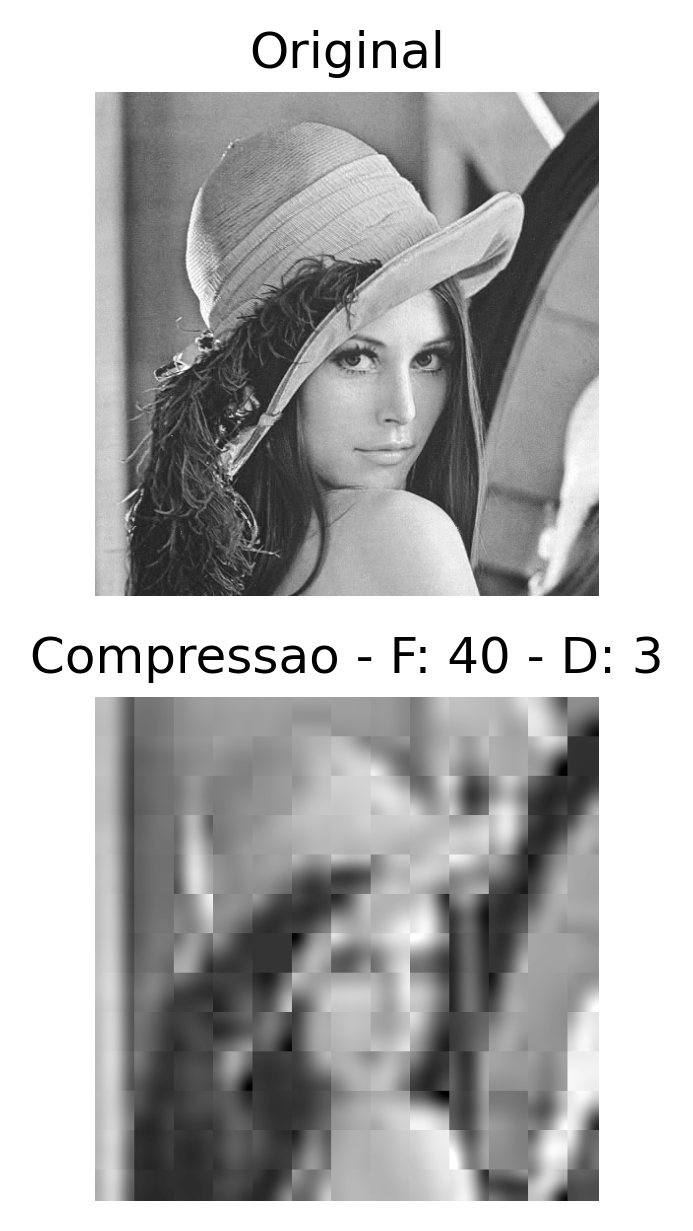

In [ ]:
# F => Dimensões F x F das janelas (chunks) - para compressão em um algoritmo tal como  JPEG
F = 40
# Limiar para remoção de frequências segundo a expresão: i+j >= d . Quanto menor, mais elementos estarão abaixo da diagonal, ou seja maiores serão as perdas de informação.
D = 3

# Testar os seguintes pares (F,D) : (40,1) , (40,3) , (40,20) , (8,1) , (8,3) , (8,5)
# Para janelas 40x40 e 8x8

# Leitura da imagem
im_path = "./imgcourse/lena.png"
image = imageio.imread(im_path)[:,:,0]



# Execução da compressão
compressed_image, n, n1, n2, Patches = compress(image)

image_width = image.shape[0]
image_height = image.shape[1]
# print("image_width = ",image_width)
# print("image_height = ",image_height)
print("Quantidade total de pixels = ",image.size)


# Salvar a imagem
cv2.imwrite("DCT_compress_example.bmp", compressed_image)

# Número de pixels anulados que podem ser comprimidos (RLE, P. ex.) após a DCT
print(f"Pixels anulados após a DCT = {n2 - n1}")
print(f"Pixels DIFERENTES DE ZERO após a DCT = {n - (n2 - n1)}")

# Percentual de pixels IDÊNTICOS (APENAS OS QUE SÃO IGUAIS A ZERO!) que podem ser comprimidos em relação a todos os pixels da imagem após a DCT
print(f"Percentual de pixels idênticos (apenas os iguais a zero, em relação a todos os pixels da imagem) que podem ser submetidos a um algoritmo de compressão (RLE, p. ex.) após a DCT = {100*(n2 - n1)/(n):.1f}%")


if image.shape[0] > image.shape[1]:
    subplots = [121, 122]
else:
    subplots = [211, 212]


# Apresentação dos resultados
print("done")
plt.subplot(subplots[0])
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title("Original")
plt.axis('off')

plt.subplot(subplots[1])
plt.title(f"Compressao - F: {F} - D: {D}")
plt.imshow(compressed_image, cmap='gray', vmin=0, vmax=255)
_ = plt.axis('off')


# Visualização da imagem anterior (após recuperação) dividida em blocos ou chunks (F x F) escolhidos

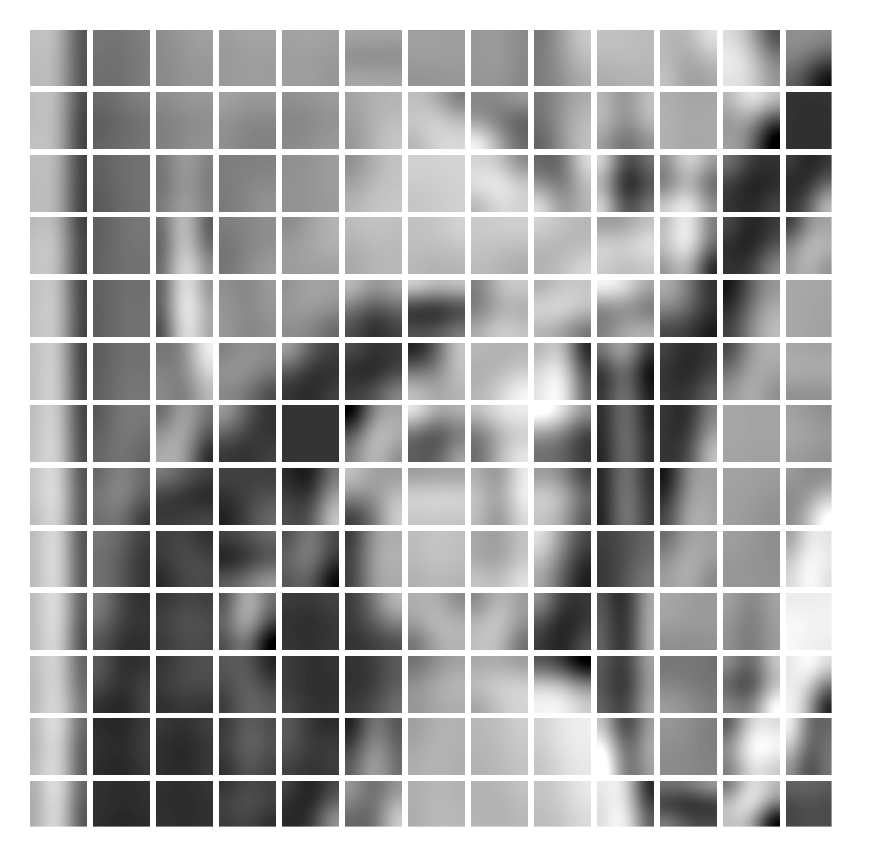

In [ ]:
def plot_grid(grid,row,col,h=3.5,w=3.5,EspacamentosHeV=0.1):
    fig, ax = plt.subplots(nrows=row, ncols=col)
    [axi.set_axis_off() for axi in ax.ravel()]

    fig.set_figheight(h)
    fig.set_figwidth(w)
    c = 0
    for row in ax:
        for col in row:
            col.imshow(grid[c], cmap='gray', vmin=0, vmax=255)
            c+=1
    plt.subplots_adjust(wspace=EspacamentosHeV, hspace=EspacamentosHeV)
    plt.show()

hor_chunks = math.ceil(image_width / F)
ver_chunks = math.ceil(image_height / F)
row, col = math.ceil(image_height / F), math.ceil(image_width / F)
# grid , r,c = img_to_grid(compressed_image,row,col)
plot_grid(Patches,row, col)
